In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import importlib
import tools.pltw as pltw

def reload_modules():
    importlib.reload(pltw)


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Tools
---

In [79]:
def analyze_process_reassignments(df):
    # Count how many times each process was moved
    process_moves = df['ProcessID'].value_counts()

    print(f"Most frequently moved processes:")
    print(process_moves.head(10))
    
    print(f"\nMovement distribution:")
    print(f"Processes moved once: {sum(process_moves == 1)}")
    print(f"Processes moved 2-5 times: {sum((process_moves >= 2) & (process_moves <= 5))}")
    print(f"Processes moved >5 times: {sum(process_moves > 5)}")
    print(f"Max moves for single process: {process_moves.max()}")
    
    return process_moves


In [ ]:
def show_reassignments_summary(df):
    print(f"Total reassignments: {len(df)}")
    print(f"Unique processes moved: {df['ProcessID'].nunique()}")
    print(f"Unique source machines: {df['SourceMachine'].nunique()}")
    print(f"Unique destination machines: {df['DestMachine'].nunique()}")
    print(f"Unique solutions: {df['SolutionId'].nunique()}")
    print(f"Initial solution cost: {df['SolutionCost'].iloc[0]}")
    print(f"Final solution cost: {df['SolutionCost'].iloc[-1]}")
    print(f"Cost improvement: {df['SolutionCost'].iloc[0] - df['SolutionCost'].iloc[-1]}")


# Approach by Jaskowski et al.
---

In [127]:
df_jask = pd.read_csv(
    '/home/pbiel/repos/mrp/jask/process_reassignments.csv',
    converters={
        'ProcessResourceRequirements': ast.literal_eval,
    }
)
df_jask['ProcessSize'] = df_jask['ProcessResourceRequirements'].apply(sum)

print(f"Solution contains {len(df_jask)} reassignments.")

# Only use first 50% of the data for analysis
#df = df.iloc[:len(df) // 2]
#print(f"Reduced to {len(df)} reassignments for analysis.")

df_jask.head()


Solution contains 2248916 reassignments.


,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,ProcessResourceRequirements,Improvement,Timestamp,...,SourceMachineCapacities,DestMachineCapacities,SourceMachineTransientUsage,DestMachineTransientUsage,SourceMachineProcessCount,DestMachineProcessCount,LoadCost,BalanceCost,SolutionCost,ProcessSize
0,1,785,20,38,20,11,1,"[699009, 1090062, 5060777]",0.0000,1755016686995,...,"[4566377,6030697,13558852]","[6300506,7600754,10262864]","[0,0,13134169]","[0,0,5050049]",15,24,390112070,242387530,632499600,6849848
1,2,785,38,47,20,11,1,"[699009, 1090062, 5060777]",6.1912,1755016686996,...,"[6300506,7600754,10262864]","[6578597,7775116,14119786]","[0,0,10110826]","[0,0,8866233]",25,28,350952610,242387530,593340351,6849848
2,3,314,20,4,20,7,1,"[537491, 770162, 3024274]",4.6252,1755016686997,...,"[4566377,6030697,13558852]","[2316751,2664501,7198664]","[0,0,13134169]","[0,0,2905168]",14,20,360857760,242387530,603245501,4331927
3,4,314,4,22,20,7,1,"[537491, 770162, 3024274]",4.0333,1755016686997,...,"[2316751,2664501,7198664]","[6312285,6208914,15886463]","[0,0,5929442]","[0,0,11726905]",21,23,364601320,242387530,606989262,4331927
4,5,314,22,32,20,7,1,"[537491, 770162, 3024274]",1.2505,1755016686998,...,"[6312285,6208914,15886463]","[4944858,5498738,7857445]","[0,0,14751179]","[0,0,4631055]",24,25,382202010,242387530,624589952,4331927


In [128]:
process_reassignments = analyze_process_reassignments(df_jask)


Most frequently moved processes:
ProcessID
140    3796
371    3664
690    3662
59     3662
241    3647
646    3640
212    3634
363    3629
77     3622
968    3610
Name: count, dtype: int64

Movement distribution:
Processes moved once: 0
Processes moved 2-5 times: 16
Processes moved >5 times: 971
Max moves for single process: 3796


In [ ]:
show_reassignments_summary(df_jask)


Total reassignments: 2248916
Unique processes moved: 987
Unique source machines: 50
Unique destination machines: 50
Unique solutions: 2332
Initial solution cost: 632499600
Final solution cost: 250808738
Cost improvement: 381690862


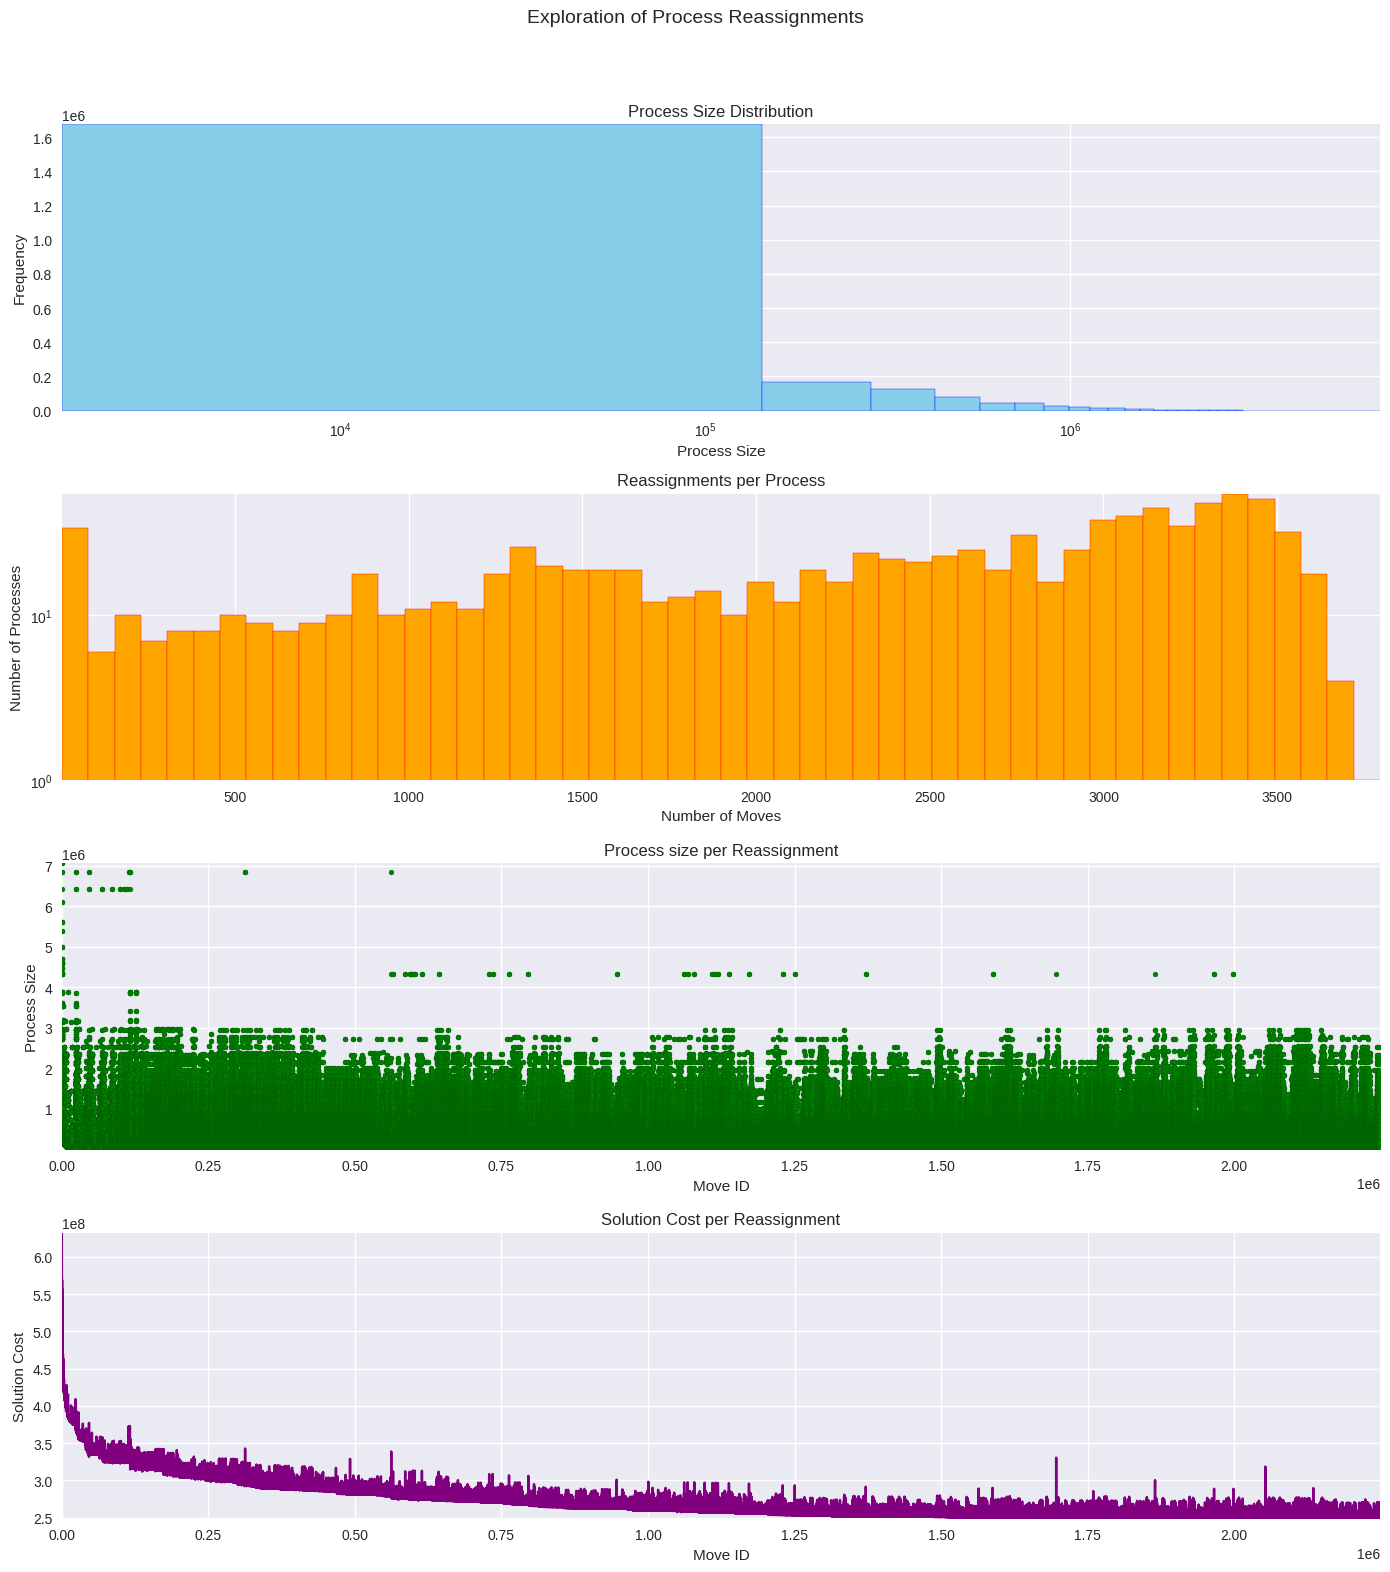

In [132]:
pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_jask['ProcessSize'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=process_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_jask['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask['SolutionCost'],
                  kwargs={"color": 'purple'}),
    ],
)


Reduced to 281114 reassignments for analysis.
Solution change points: [0, 2, 42, 57, 105] ... [274437, 274813, 275808, 280474, 281114]


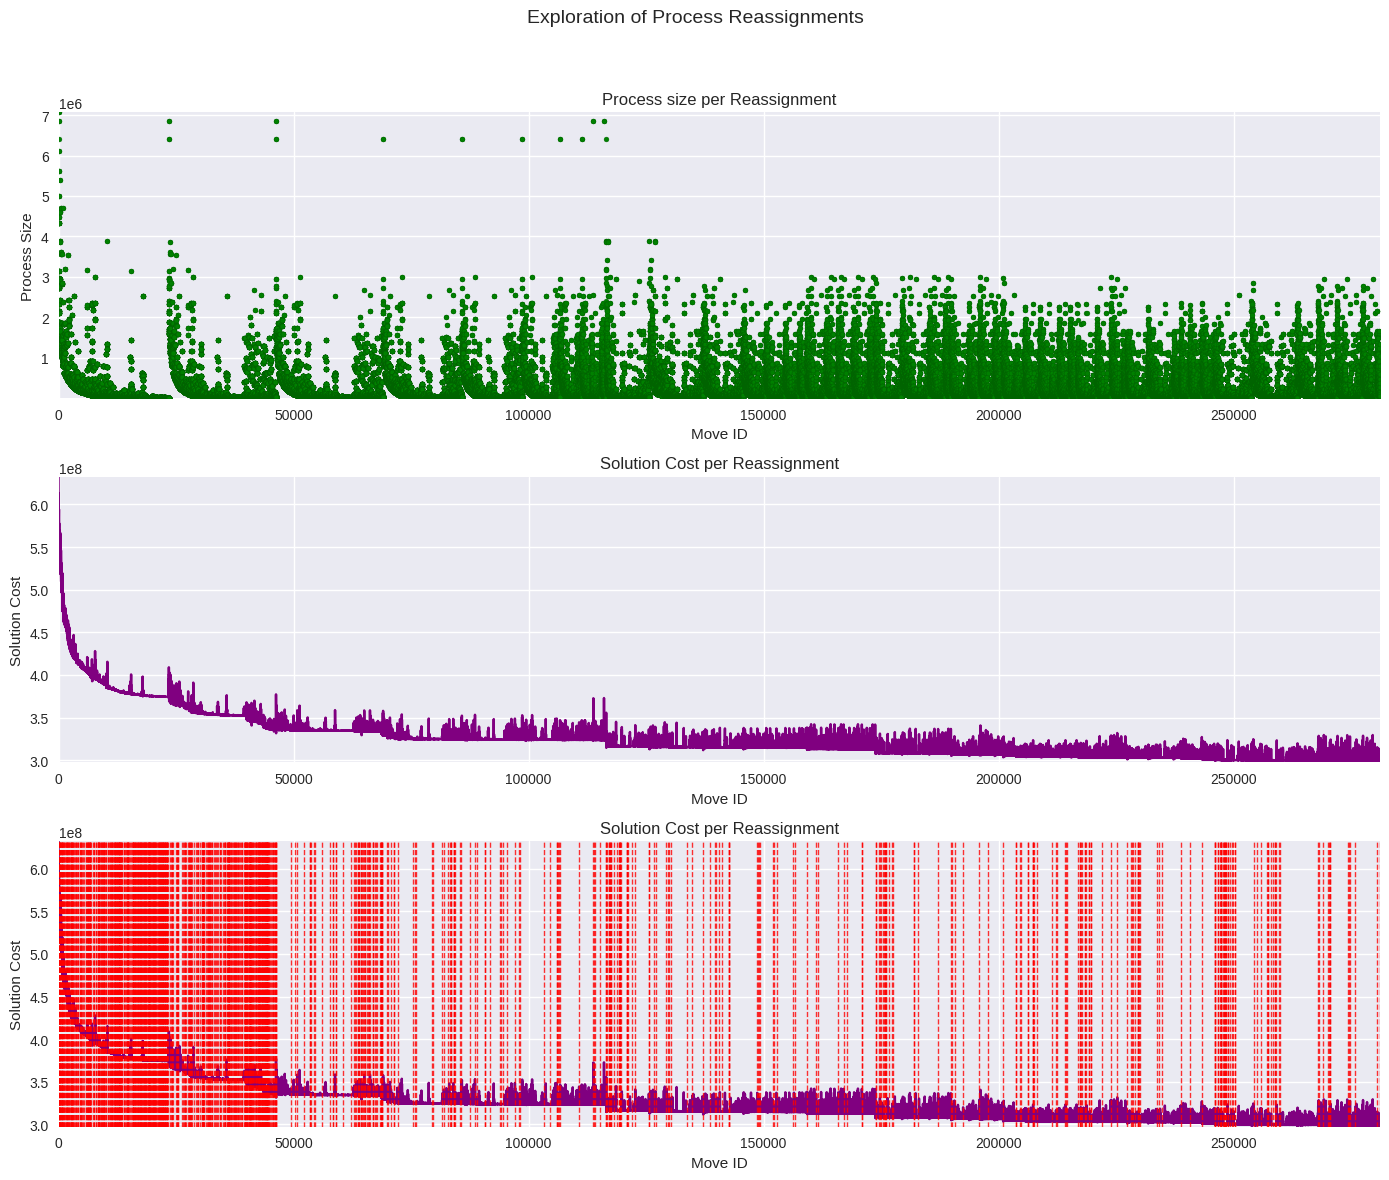

In [133]:
df_jask_partial = df_jask.iloc[:len(df_jask) // 8]
print(f"Reduced to {len(df_jask_partial)} reassignments for analysis.")

sol_mask = df_jask_partial['SolutionId'].ne(df_jask_partial['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df_jask_partial)]  # Include start and end of DataFrame
print(f"Solution change points: {sol_change_points[:5]} ... {sol_change_points[-5:]}")

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_jask_partial['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask_partial['SolutionCost'],
                  kwargs={"color": 'purple'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask_partial['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple'}),
    ],
)


# Approach by Gavranovic et al.
---

In [117]:
df_gavra = pd.read_csv(
    '/home/pbiel/repos/mrp/gavra/results_a1_4_20250812_174356/process_reassignments_sol1.csv',
    converters={
        'ProcessResourceRequirements': ast.literal_eval,
    }
)
df_gavra['ProcessTotalReq'] = df_gavra['ProcessResourceRequirements'].apply(sum)

print(f"Solution contains {len(df_gavra)} reassignments.")
df_gavra.head()

# Only use first 25% of the data for analysis
#df = df.iloc[:len(df) // 4]
print(f"Reduced to {len(df_gavra)} reassignments for analysis.")

df_gavra.head()


Solution contains 9575 reassignments.
Reduced to 9575 reassignments for analysis.


,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,ProcessResourceRequirements,Improvement,Timestamp,...,SourceMachineCapacities,DestMachineCapacities,SourceMachineTransientUsage,DestMachineTransientUsage,SourceMachineProcessCount,DestMachineProcessCount,LoadCost,BalanceCost,SolutionCost,ProcessTotalReq
0,1,1,8,14,48,8,1,"[35574, 21914, 48459]",0.0,1755017044000,...,"[2344071,3031239,3573218]","[3233735,3655313,8642089]","[1759408,2076047,3059201]","[2737196,2642254,8566626]",12,34,395942500,2426474200,2823506710,105947
1,2,2,0,11,34,17,1,"[6429, 4024, 17106]",0.0,1755017044000,...,"[722040,645675,789895]","[2972420,2877021,6716092]","[624553,488000,754104]","[2871011,2688144,6723251]",11,19,396330900,2426474200,2823895110,27559
2,3,6,16,47,16,2,1,"[171832, 137485, 49123]",0.0,1755017044000,...,"[4087795,4462350,9561546]","[6578597,7775116,14119786]","[3261202,3022402,8608708]","[5779889,7051162,14027127]",16,29,413013500,2426474200,2840579720,358440
3,4,9,47,32,47,81,1,"[3738, 1896, 2877]",0.0,1755017044000,...,"[6578597,7775116,14119786]","[4944858,5498738,7857445]","[5776151,7049266,14027127]","[4373714,4377855,7858431]",28,21,412829300,2426474200,2840397530,8511
4,5,11,26,20,14,4,1,"[421150, 835413, 82703]",0.0,1755017044000,...,"[2940295,3772766,10030869]","[4566377,6030697,13558852]","[1650034,1957009,9936272]","[3815227,5757139,13530853]",9,13,524503900,2426474200,2952072130,1339266


In [123]:
print(f"Total reassignments: {len(df_gavra)}")
print(f"Unique processes moved: {df_gavra['ProcessID'].nunique()}")
print(f"Unique source machines: {df_gavra['SourceMachine'].nunique()}")
print(f"Unique destination machines: {df_gavra['DestMachine'].nunique()}")
print(f"Unique solutions: {df_gavra['SolutionId'].nunique()}")
print(f"Initial solution cost: {df_gavra['SolutionCost'].iloc[0]}")
print(f"Final solution cost: {df_gavra['SolutionCost'].iloc[-1]}")
print(f"Cost improvement: {df_gavra['SolutionCost'].iloc[0] - df_gavra['SolutionCost'].iloc[-1]}")


Total reassignments: 9575
Unique processes moved: 885
Unique source machines: 50
Unique destination machines: 50
Unique solutions: 17
Initial solution cost: 2823506710
Final solution cost: 2738333980
Cost improvement: 85172730


Analysis into:
- Process distribution by size
- Process reassignments distribution by size
- Process reassignments over solution
- Solution Cost across reassignments
- Solution Cost Improvement across reassignments

In [120]:
process_reassignments = analyze_process_reassignments(df_gavra)


Most frequently moved processes:
ProcessID
76     17
991    17
59     17
74     17
983    17
104    17
947    17
976    17
764    17
829    17
Name: count, dtype: int64

Movement distribution:
Processes moved once: 40
Processes moved 2-5 times: 122
Processes moved >5 times: 723
Max moves for single process: 17


In [14]:
reload_modules()


In [96]:
# Get unique process sizes by process ID
unique_process_sizes = df.groupby('ProcessID')['ProcessTotalReq'].first().reset_index()
print(f"Unique process sizes:\n{unique_process_sizes}")

process_size_quantiles = unique_process_sizes['ProcessTotalReq'].quantile([0.25, 0.5, 0.75, 1.0])
print(f"Process size quantiles:\n{process_size_quantiles}")

# Calculate portion of processes under 25% quantile
process_under_25 = unique_process_sizes[unique_process_sizes['ProcessTotalReq'] < process_size_quantiles[0.25]]
print(f"Processes under 25% quantile ({process_size_quantiles[0.25]}): {len(process_under_25)} out of {len(unique_process_sizes)}")
print(f"Size {process_size_quantiles[0.25]} is {process_size_quantiles[0.25] / unique_process_sizes['ProcessTotalReq'].max() * 100:.2f}% of the largest process size ({unique_process_sizes['ProcessTotalReq'].max()})")


Unique process sizes:
   ProcessID  ProcessTotalReq
0          1           860648
1         28           729579
2         34           584451
3         35           506071
4         36          1005296
5         58          1662580
6         74          1141047
7         94           971475
8         95          1198814
Process size quantiles:
0.25     729579.0
0.50     971475.0
0.75    1141047.0
1.00    1662580.0
Name: ProcessTotalReq, dtype: float64
Processes under 25% quantile (729579.0): 2 out of 9
Size 729579.0 is 43.88% of the largest process size (1662580)


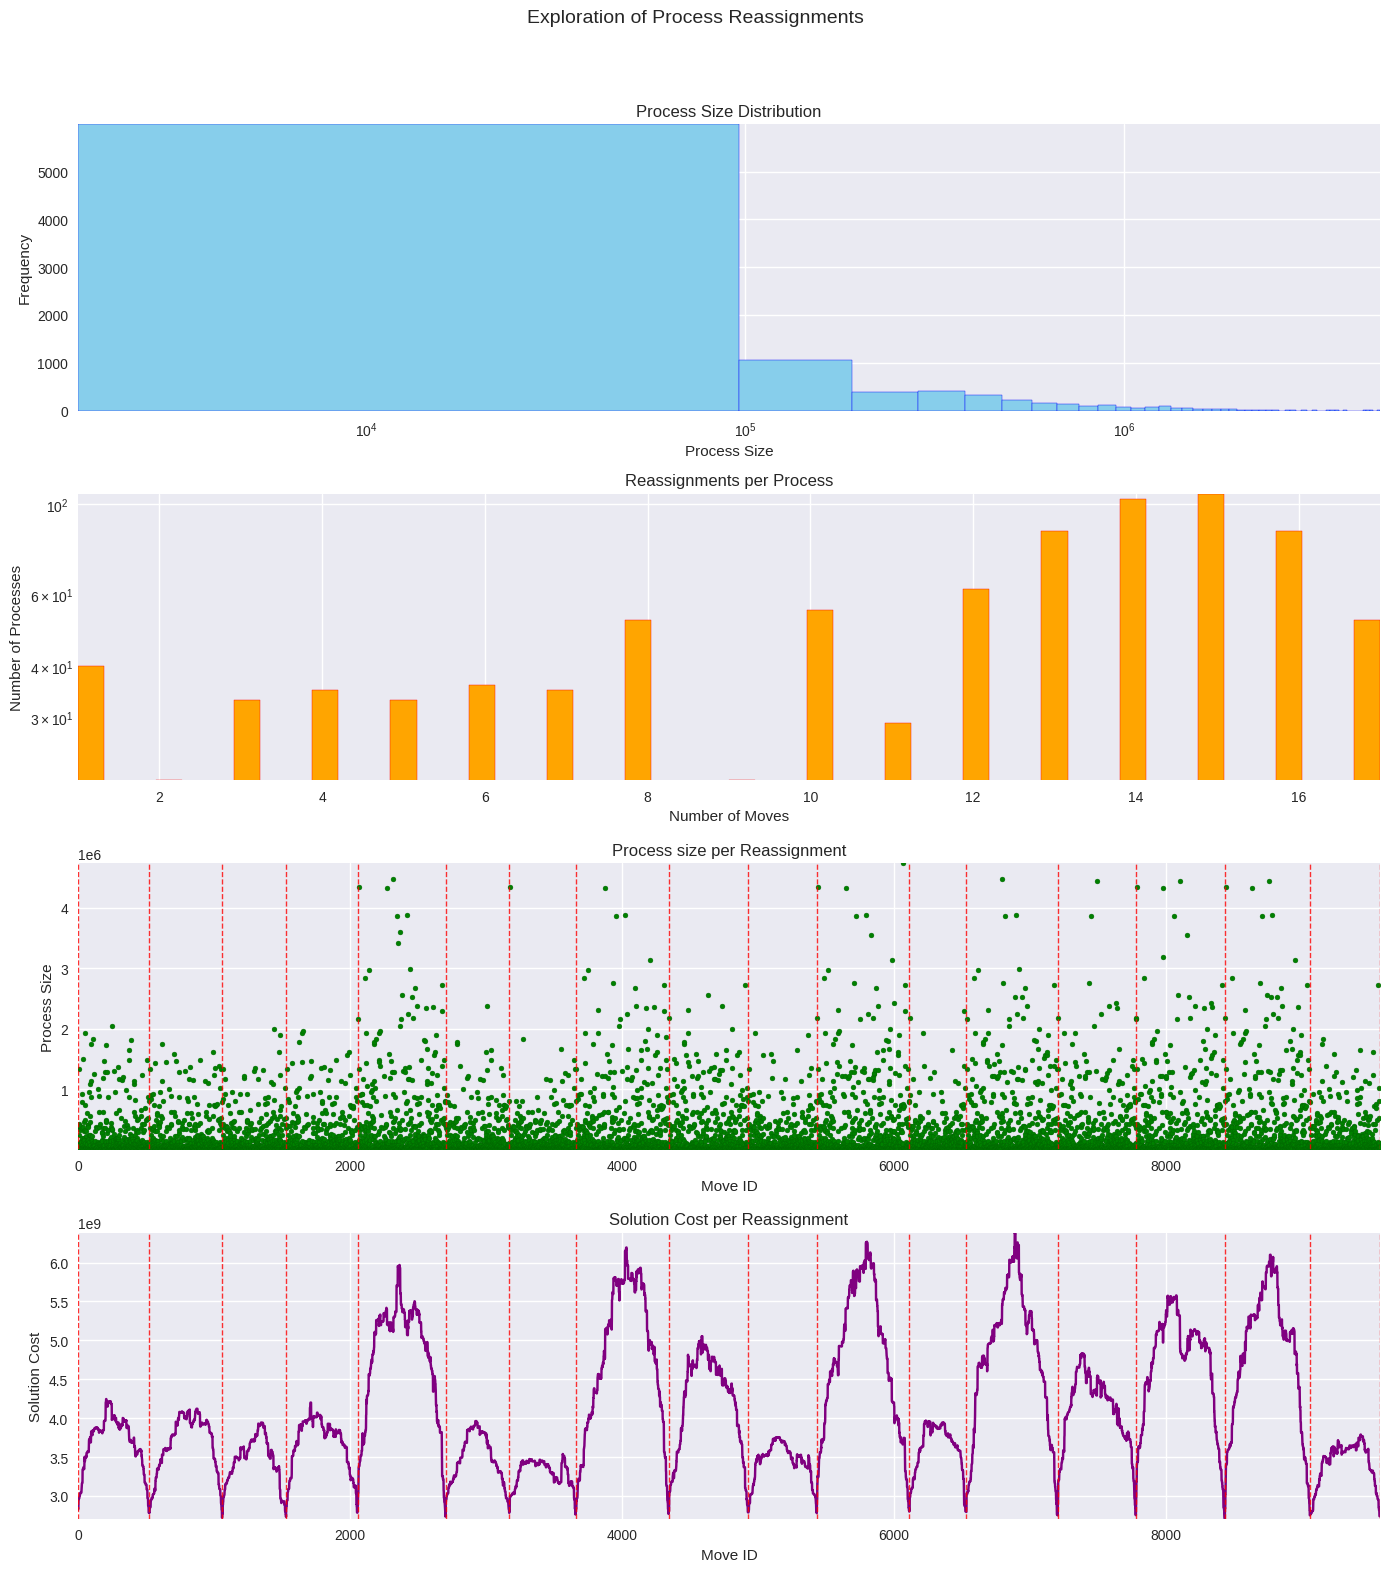

In [124]:
sol_mask = df_gavra['SolutionId'].ne(df_gavra['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df_gavra)]  # Include start and end of DataFrame

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_gavra['ProcessTotalReq'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=process_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_gavra['ProcessTotalReq'],
                  vlines=sol_change_points,
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_gavra['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple'}),
    ],
)


- Solution state changes

Solution change points: [0, 3, 6, 9, 12] ... [1626, 1629, 1633, 1636, 1641]


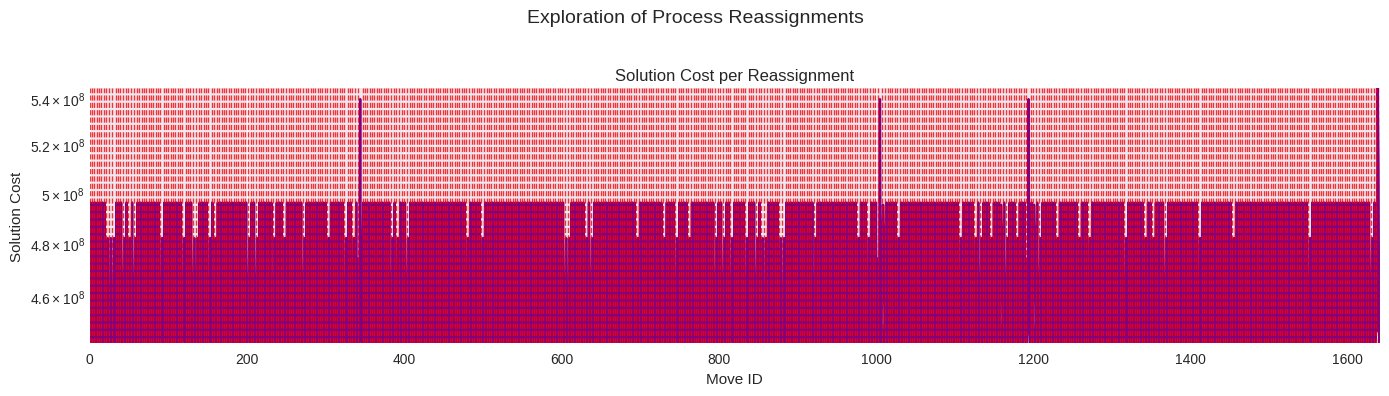

In [98]:
sol_mask = df['SolutionId'].ne(df['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df)]  # Include start and end of DataFrame
print(f"Solution change points: {sol_change_points[:5]} ... {sol_change_points[-5:]}")

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple', "yscale": 'log'}),
    ]
)


# Approach by Mehta et al.
---

In [ ]:
df_mehta = pd.read_csv('/home/pbiel/repos/mrp/mehta/cblns/reassignment_a1_4.txt_tracking.csv')
lookup = (
    df_jask[['ProcessID', 'ProcessSize']]
    .drop_duplicates('ProcessID')
    .set_index('ProcessID')['ProcessSize']
)
df_mehta = df_mehta.copy()
df_mehta['ProcessSize'] = df_mehta['processId'].map(lookup)
df_mehta['ProcessSize'] = df_mehta['ProcessSize'].fillna(0).astype(int)

print(f"Solution contains {len(df_mehta)} reassignments.")
df_mehta.head()


Solution contains 25440 reassignments.


,moveNumber,processId,sourceMachine,destMachine,moveCost,improvement,timestamp,solutionId,solutionCost,ProcessSize
0,1,973,20,47,0,0,0.0,1,601689777,128112
1,2,378,20,47,0,0,0.0,1,601689777,214233
2,3,756,20,12,0,0,0.0,1,601689777,1115028
3,4,844,20,33,0,0,0.0,1,601689777,2432081
4,5,638,20,38,0,0,0.0,1,601689777,1323574


In [ ]:
process_reassignments = df_mehta['processId'].value_counts()

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_mehta['ProcessSize'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=process_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_mehta['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_mehta['SolutionCost'],
                  kwargs={"color": 'purple'}),
    ],
)


KeyError: 'ProcessID'